### Required dependencies
You'll need recent versions of Jupyter (but if you're reading this, you are probably OK), scikit-learn, numpy, pandas and matplotlib and/or seaborn. The most recent versions should be fine. You are free to use any other package under the sun, but I suspect you will be at least needing the above.

I advise you to use a form of virtual environments to manage your python projects (e.g. pipenv, venv, conda etc.).

To get free GPU time, you can try Google Colab. It is a tool for running notebooks like this on the fly, and provides you with a VM and a GPU for free. Almost all packages for machine learning are automatically installed, and I suspect you could the entire project on Colab if you wanted to. Still, it is useful to learn how to set up your environment on your own pc as well, and Colab is a bit more complicated when you have to import your datasets (best to import them from a Google Drive for speed). Colab could become useful if you intend to try the deep learning approaches with TensorFlow and PyTorch, and you don't have a GPU yourself.

In [37]:
# numerical library:
import numpy as np

# data manipulation library:
import pandas as pd

# standard packages used to handle files:
import sys
import os 
import glob
import time

# scikit-learn machine learning library:
import sklearn

# plotting:
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from matplotlib import patches
import seaborn as sns


# tell matplotlib that we plot in a notebook:
# %matplotlib notebook

Define your folder structure with your data:

In [38]:
data_folder = "./"

In [39]:
train_data = pd.read_csv(data_folder + "train.csv")
test_data = pd.read_csv(data_folder + "test.csv")
# Drop the date column from test
test_data = test_data.drop(["date"], axis=1)

### Data exploration
Let's take a look at our train and test data:

In [40]:
train_data.head()

,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
0,2016-01-11 17:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
1,2016-01-11 17:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2,2016-01-11 17:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
3,2016-01-11 17:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,50
4,2016-01-11 17:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


In [41]:
train_data.dtypes

date            object
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
Appliances       int64
dtype: object

Let's take a look at our first 1000 datapoints in the training set:

In [42]:
train_data.describe()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,4.389333,21.150644,40.223645,19.658822,40.688595,21.563270,39.545294,20.136782,39.118823,18.938388,...,41.669635,5.904323,755.512243,81.749333,4.299733,38.760367,2.761777,24.989925,24.989925,98.751333
std,8.453314,1.235377,3.570557,1.524552,3.387494,1.525732,3.149775,1.540814,4.269767,1.318223,...,3.958103,4.189812,7.928961,12.980934,2.589470,12.570409,3.577249,14.508441,14.508441,106.421877
min,0.000000,16.790000,27.733333,16.100000,25.763333,17.200000,32.626667,15.100000,27.660000,15.330000,...,31.033333,-5.000000,729.300000,31.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,0.000000,20.390000,37.590000,18.600000,38.400000,20.463333,37.230000,19.166667,35.700000,18.000000,...,38.700000,2.983333,750.650000,73.000000,2.000000,29.000000,0.366667,12.566582,12.566582,50.000000
50%,0.000000,21.290000,39.790000,19.600000,40.760000,21.600000,38.831667,20.206481,38.500000,18.890000,...,40.966667,5.850000,756.166667,85.250000,4.000000,40.000000,2.833333,24.858659,24.858659,60.000000
75%,10.000000,22.033333,42.933333,20.666667,43.290000,22.600000,42.000000,21.260000,42.090000,20.000000,...,44.246607,8.966667,761.766667,92.000000,6.000000,40.000000,5.300000,37.675790,37.675790,100.000000
max,70.000000,24.100000,63.360000,24.600000,56.026667,27.600000,50.163333,23.760000,51.090000,22.967778,...,53.326667,19.700000,772.300000,100.000000,14.000000,66.000000,11.400000,49.996530,49.996530,1080.000000


In [43]:
train_data_temp = train_data.copy()
# Drop the date column
train_data_temp = train_data_temp.drop(["date"], axis=1)
train_data_temp.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
0,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
1,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
3,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,50
4,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


In [44]:
train_data_temp.corr()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
lights,1.000000,0.092859,0.149226,0.123325,0.051636,-0.017164,0.150710,0.116495,0.131148,0.005402,...,0.001526,-0.013318,-0.009154,0.047729,0.037738,0.015345,0.021450,-0.003072,-0.003072,0.223585
T1,0.092859,1.000000,0.022486,0.770547,-0.015411,0.816525,-0.089806,0.752710,-0.010284,0.797897,...,-0.055826,0.441579,-0.149507,-0.254685,0.049154,-0.054255,0.322605,-0.005087,-0.005087,0.087258
RH_1,0.149226,0.022486,1.000000,0.264038,0.790911,0.121259,0.837415,-0.082896,0.855006,0.067733,...,0.715624,0.361673,-0.251135,0.258274,0.306311,-0.020426,0.605811,-0.003434,-0.003434,0.090329
T2,0.123325,0.770547,0.264038,1.000000,-0.111158,0.575122,0.204770,0.573002,0.258420,0.565379,...,0.145629,0.597790,-0.150003,-0.393215,0.251975,-0.065477,0.400001,-0.005526,-0.005526,0.157046
RH_2,0.051636,-0.015411,0.790911,-0.111158,1.000000,0.173080,0.631004,-0.086679,0.700076,0.144692,...,0.629805,0.202693,-0.223372,0.492143,0.125635,0.001125,0.593173,-0.001154,-0.001154,-0.059584
T3,-0.017164,0.816525,0.121259,0.575122,0.173080,1.000000,-0.099201,0.727089,-0.010335,0.821112,...,0.002376,0.508110,-0.216960,-0.230845,0.051684,-0.095963,0.418853,-0.003196,-0.003196,0.126482
RH_3,0.150710,-0.089806,0.837415,0.204770,0.631004,-0.099201,1.000000,-0.271640,0.902797,-0.142442,...,0.829494,0.149804,-0.183498,0.345917,0.335664,0.008168,0.419339,-0.002117,-0.002117,0.034468
T4,0.116495,0.752710,-0.082896,0.573002,-0.086679,0.727089,-0.271640,1.000000,-0.246150,0.752717,...,-0.222248,0.404930,-0.038604,-0.355113,-0.096428,-0.095548,0.207633,0.000881,0.000881,0.074127
RH_4,0.131148,-0.010284,0.855006,0.258420,0.700076,-0.010335,0.902797,-0.246150,1.000000,-0.029515,...,0.850997,0.322947,-0.203515,0.350118,0.382819,0.008836,0.622001,-0.003560,-0.003560,-0.001280
T5,0.005402,0.797897,0.067733,0.565379,0.144692,0.821112,-0.142442,0.752717,-0.029515,1.000000,...,-0.069337,0.437593,-0.203299,-0.187191,-0.047250,-0.065828,0.365980,-0.007865,-0.007865,0.034020


In [45]:
# lights , T2,T3 T6,RH_out are high corelated with Appliances
train_data_temp.corrwith(train_data_temp["Appliances"])

lights         0.223585
T1             0.087258
RH_1           0.090329
T2             0.157046
RH_2          -0.059584
T3             0.126482
RH_3           0.034468
T4             0.074127
RH_4          -0.001280
T5             0.034020
RH_5          -0.003534
T6             0.118191
RH_6          -0.081692
T7             0.052300
RH_7          -0.069853
T8             0.070779
RH_8          -0.115603
T9             0.027337
RH_9          -0.062399
T_out          0.102267
Press_mm_hg   -0.041420
RH_out        -0.148025
Windspeed      0.076209
Visibility    -0.007147
Tdewpoint      0.015312
rv1           -0.008751
rv2           -0.008751
Appliances     1.000000
dtype: float64

In [46]:
# T_out and T6 high corelation 
corr_matrix = train_data_temp.corr()


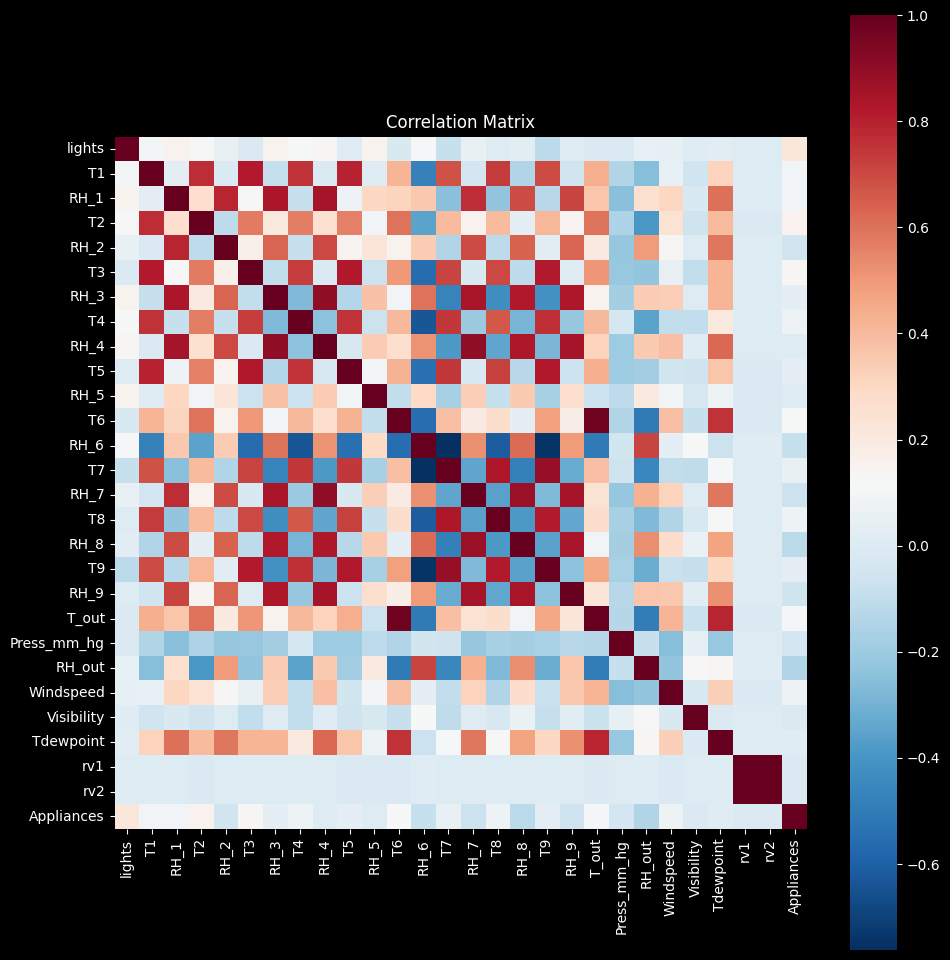

In [47]:
plt.figure(figsize=(10,10))  # Set the size of your figure, customize for your needs.
sns.heatmap(corr_matrix, annot=False, fmt=".2f", square=True, cmap='RdBu_r')  
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

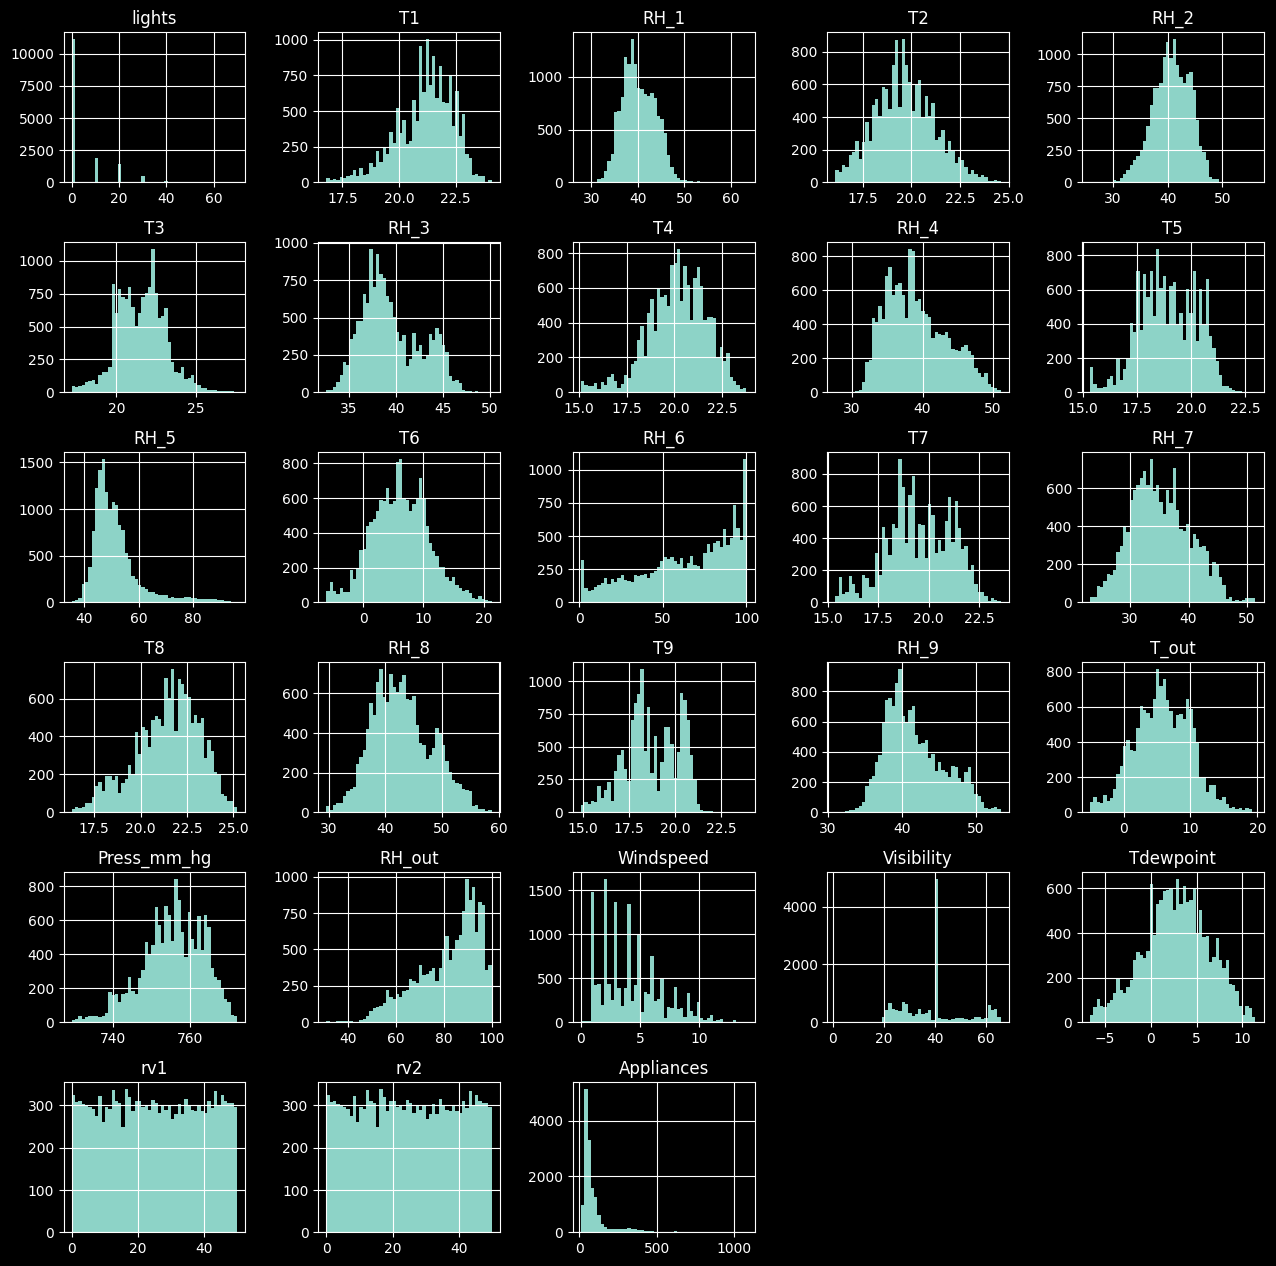

In [48]:
# train_data_temp.hist(figsize=(10, 10))

# RH_out light are skewed T1,RH_1,T2,RH2 data are normaly distributed
# Plot histograms with a specified layout and size
train_data_temp.hist(bins=50, figsize=(15, 15))

# Add margins around each histogram using subplots_adjust
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.4, hspace=0.4)

plt.show()

## Lights
On average 60 Wh light is high, when the energy usage of the lights is 60 Wh (watt-hours), the energy usage of the appliances in the house is around 600 Wh.

However, this does not mean that the light fixtures themselves are high energy consumers or that they are directly responsible for the energy usage of the appliances. lights and Appliances are measurements of different systems within the house.

<Axes: xlabel='lights'>

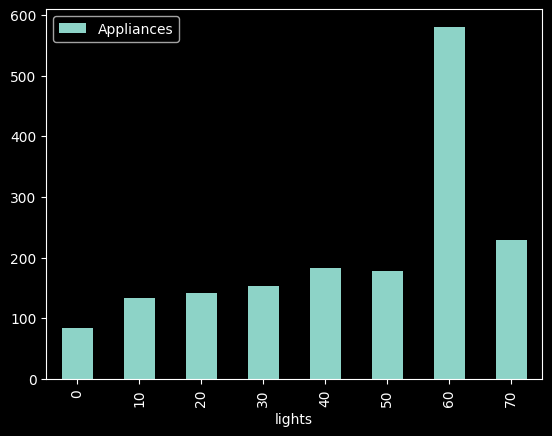

In [50]:
train_data_temp.loc[:, ["lights", "Appliances"]].groupby("lights").mean().plot.bar()

## T1

T1, Temperature in kitchen area, in Celsius

When the kitchen temperature T1 is colder around 16-17 degrees Celsius the average energy consumption of appliances tends to be higher (around 140 Wh). This might be because heating appliances or others like ovens are used more. On the other hand, when the kitchen is warmer around 22-23 degrees Celsius, the average energy consumption of appliances decreases to around 120 Wh, possibly because heating appliances are used less or other appliances are used more efficiently.

Minimum value of T1: 16.79
Maximum value of T1: 24.1


<Axes: xlabel='T1_binned'>

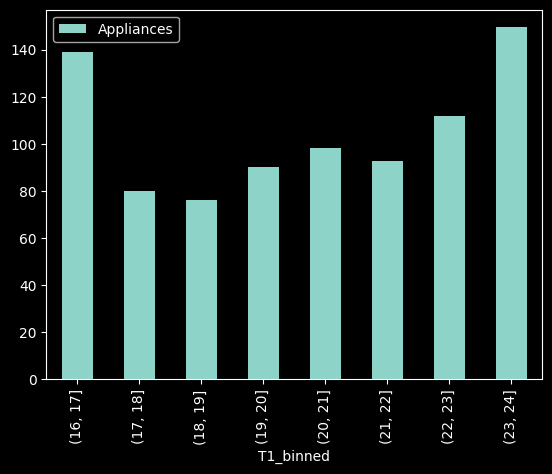

In [58]:
min_T1 = train_data_temp['T1'].min()
max_T1 = train_data_temp['T1'].max()

print(f"Minimum value of T1: {min_T1}")
print(f"Maximum value of T1: {max_T1}")

# Bin edges.
bin_edges = np.arange(16, 25, 1) # Fixed bin size of 1
# Bin the data into discrete intervals.
train_data_temp['T1_binned'] = pd.cut(train_data_temp['T1'], bins=bin_edges)

# Average Appliances energy use for each bin.
train_data_temp.loc[:, ["T1_binned", "Appliances"]].groupby("T1_binned").mean().plot.bar()


## RH_1

RH_1, Humidity in kitchen area, in %

When the kitchen humidity is lower (27-29%), appliances use more energy (175 Wh). When it's more humid (57-59%), they use less energy (100 Wh).

This could be due to various factors, such as increased use of dehumidifiers or air conditioning, or changes in how other appliances perform under these conditions.



Minimum value of RH_1: 27.73333333333329
Maximum value of RH_1: 63.36


<Axes: xlabel='RH_1_binned'>

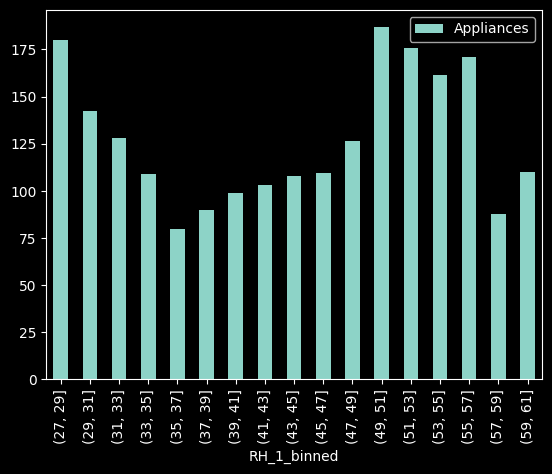

In [62]:
min_RH_1 = train_data_temp['RH_1'].min()
max_RH_1 = train_data_temp['RH_1'].max()

print(f"Minimum value of RH_1: {min_RH_1}")
print(f"Maximum value of RH_1: {max_RH_1}")

bin_edges = np.arange(27, 63, 2) 
train_data_temp['RH_1_binned'] = pd.cut(train_data_temp['RH_1'], bins=bin_edges)

train_data_temp.loc[:, ["RH_1_binned", "Appliances"]].groupby("RH_1_binned").mean().plot.bar()


## T2

T2, Temperature in living room area, in Celsius

When the temperature between 16-18 degrees appliances use less energy around 70-80 Wh. This might be because less energy needed for heating or cooling. However when the temperature increases to between 22-23 degrees the energy usage of appliances increases to about 150 Wh. This could be due to increased use of cooling appliances like air conditioners or fans.

Minimum value of T2: 16.1
Maximum value of T2: 24.6


<Axes: xlabel='T2_binned'>

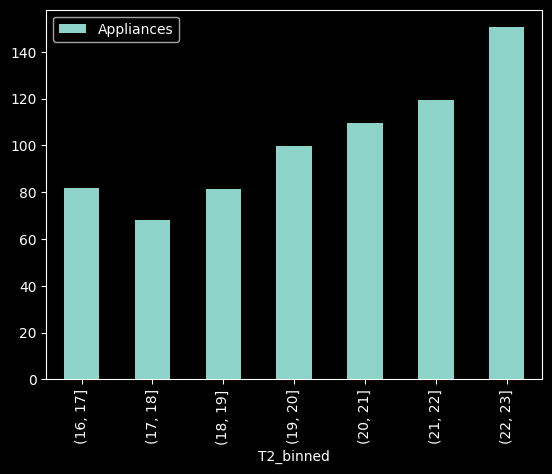

In [64]:
min_T2 = train_data_temp['T2'].min()
max_T2 = train_data_temp['T2'].max()

print(f"Minimum value of T2: {min_T2}")
print(f"Maximum value of T2: {max_T2}")

bin_edges = np.arange(16, 24, 1)
train_data_temp['T2_binned'] = pd.cut(train_data_temp['T2'], bins=bin_edges)

train_data_temp.loc[:, ["T2_binned", "Appliances"]].groupby("T2_binned").mean().plot.bar()


## RH_2

RH_2, Humidity in living room area, in %

As humidity in the living room changes from low (25-30%) to moderate (45-50%) to high (50-55%) appliance energy usage first decreases from 175 Wh to 100 Wh then increases back up to 200 Wh possibly indicating the use of appliances to manage excessive humidity such as air conditioners or dehumidifiers.

Minimum value of RH_2: 25.7633333333333
Maximum value of RH_2: 56.0266666666667


<Axes: xlabel='RH_2_binned'>

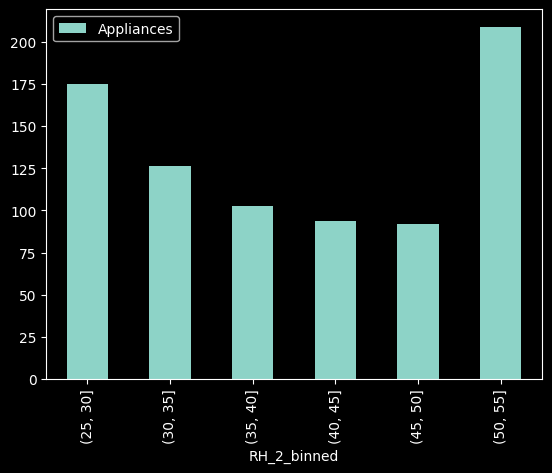

In [70]:
min_RH_2 = train_data_temp['RH_2'].min()
max_RH_2 = train_data_temp['RH_2'].max()

print(f"Minimum value of RH_2: {min_RH_2}")
print(f"Maximum value of RH_2: {max_RH_2}")

bin_edges = np.arange(25, 56, 5)
train_data_temp['RH_2_binned'] = pd.cut(train_data_temp['RH_2'], bins=bin_edges)

train_data_temp.loc[:, ["RH_2_binned", "Appliances"]].groupby("RH_2_binned").mean().plot.bar()


## T3

T3, Temperature in laundry room area

As the temperature in the laundry room increases for example from 50 to 55 degrees Celsius, the energy usage of appliances also increases to around 200 Wh, potentially indicating more use of appliances like washers or dryers in warmer conditions.

Minimum value of T3: 17.2
Maximum value of T3: 27.6


<Axes: xlabel='T3_binned'>

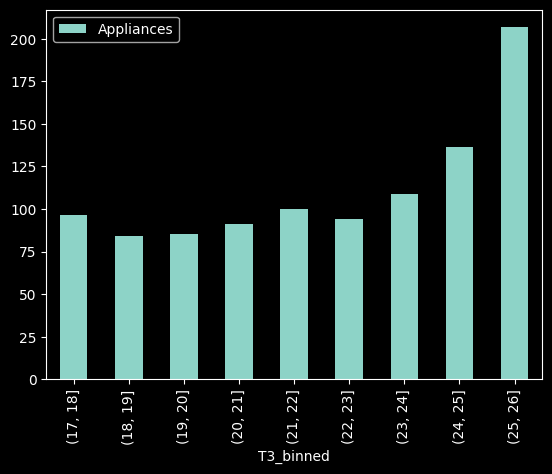

In [73]:
min_T3 = train_data_temp['T3'].min()
max_T3 = train_data_temp['T3'].max()

print(f"Minimum value of T3: {min_T3}")
print(f"Maximum value of T3: {max_T3}")

bin_edges = np.arange(17, 27, 1)
train_data_temp['T3_binned'] = pd.cut(train_data_temp['T3'], bins=bin_edges)

train_data_temp.loc[:, ["T3_binned", "Appliances"]].groupby("T3_binned").mean().plot.bar()


## RH_3

RH_3, Humidity in laundry room area, in %

As the humidity in the laundry room increases from around 32%-34% to 46%-48% the average energy usage of appliances also rises from approximately 120 Wh to 140 Wh. This suggests that higher humidity levels could be associated with increased use or efficiency of certain appliances.

Minimum value of RH_3: 32.6266666666667
Maximum value of RH_3: 50.1633333333333


<Axes: xlabel='RH_3_binned'>

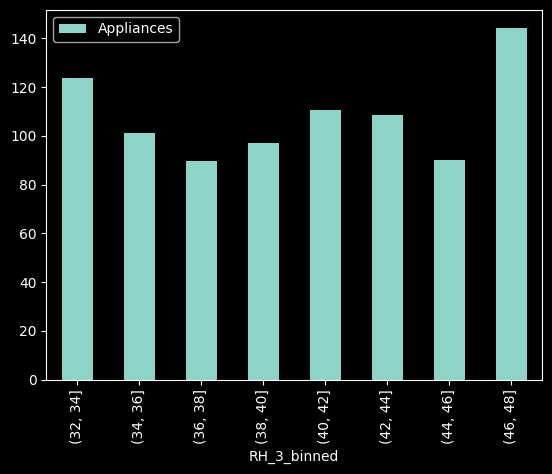

In [76]:
min_RH_3 = train_data_temp['RH_3'].min()
max_RH_3 = train_data_temp['RH_3'].max()

print(f"Minimum value of RH_3: {min_RH_3}")
print(f"Maximum value of RH_3: {max_RH_3}")

bin_edges = np.arange(32, 50, 2)
train_data_temp['RH_3_binned'] = pd.cut(train_data_temp['RH_3'], bins=bin_edges)

train_data_temp.loc[:, ["RH_3_binned", "Appliances"]].groupby("RH_3_binned").mean().plot.bar()


## T4

T4, Temperature in office room, in Celsius

As the office room temperature rises from 15-16°C to 21-22°C, the energy consumption by appliances increases from 70 Wh to 120 Wh. This implies that higher temperatures might cause higher energy usage by the appliances in the office room.


Minimum value of T4: 15.1
Maximum value of T4: 23.76


<Axes: xlabel='T4_binned'>

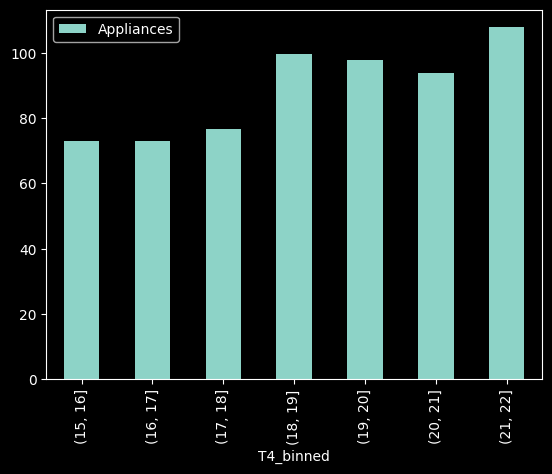

In [79]:
min_T4 = train_data_temp['T4'].min()
max_T4 = train_data_temp['T4'].max()

print(f"Minimum value of T4: {min_T4}")
print(f"Maximum value of T4: {max_T4}")

bin_edges = np.arange(15, 23, 1)
train_data_temp['T4_binned'] = pd.cut(train_data_temp['T4'], bins=bin_edges)

train_data_temp.loc[:, ["T4_binned", "Appliances"]].groupby("T4_binned").mean().plot.bar()


## RH_4

RH_4, Humidity in office room, in %

In the office room, as humidity levels rise from 27-30% to 45-48%, the energy usage by appliances decreases from 150 Wh to 85 Wh. This suggests that appliances in the office room might use less energy when the humidity is higher.

Minimum value of RH_4: 27.66
Maximum value of RH_4: 51.09


<Axes: xlabel='RH_4_binned'>

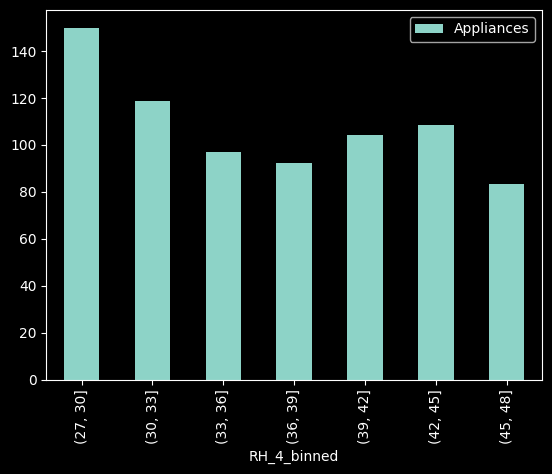

In [82]:
min_RH_4 = train_data_temp['RH_4'].min()
max_RH_4 = train_data_temp['RH_4'].max()

print(f"Minimum value of RH_4: {min_RH_4}")
print(f"Maximum value of RH_4: {max_RH_4}")

bin_edges = np.arange(27, 51, 3)
train_data_temp['RH_4_binned'] = pd.cut(train_data_temp['RH_4'], bins=bin_edges)

train_data_temp.loc[:, ["RH_4_binned", "Appliances"]].groupby("RH_4_binned").mean().plot.bar()


## T5

T5, Temperature in bathroom, in Celsius

In the bathroom, when the temperature is between 16-17 degrees Celsius, the energy usage by appliances is the lowest at 65 Wh. However, when the temperature is either lower 15-16 degrees or higher 19-21 degrees the energy usage increases, with the highest being 110 Wh at 20-21 degrees Celsius.The change in energy use of appliances with bathroom temperature may be due to increased use of heating or cooling devices during colder or warmer temperatures respectively.


Minimum value of T5: 15.33
Maximum value of T5: 22.9677777777778


<Axes: xlabel='T5_binned'>

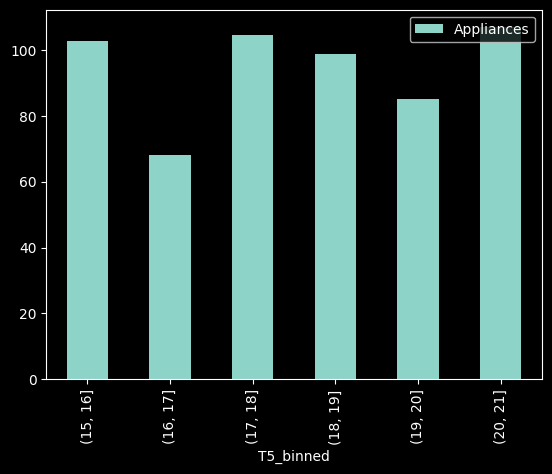

In [87]:
min_T5 = train_data_temp['T5'].min()
max_T5 = train_data_temp['T5'].max()

print(f"Minimum value of T5: {min_T5}")
print(f"Maximum value of T5: {max_T5}")

bin_edges = np.arange(15, 22, 1)
train_data_temp['T5_binned'] = pd.cut(train_data_temp['T5'], bins=bin_edges)

train_data_temp.loc[:, ["T5_binned", "Appliances"]].groupby("T5_binned").mean().plot.bar()


## RH_5

RH_5, Humidity in bathroom, in %

The energy usage of appliances varies with humidity in the bathroom, dropping at mid-ranges but increasing again at high and low levels, suggesting appliances might be used more when the humidity is either very low or high.

Minimum value of RH_5: 35.3633333333333
Maximum value of RH_5: 96.3216666666667


<Axes: xlabel='RH_5_binned'>

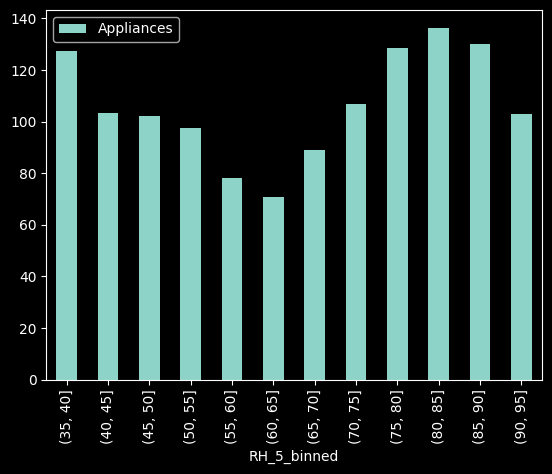

In [89]:
min_RH_5 = train_data_temp['RH_5'].min()
max_RH_5 = train_data_temp['RH_5'].max()

print(f"Minimum value of RH_5: {min_RH_5}")
print(f"Maximum value of RH_5: {max_RH_5}")

bin_edges = np.arange(35, 96, 5)
train_data_temp['RH_5_binned'] = pd.cut(train_data_temp['RH_5'], bins=bin_edges)

train_data_temp.loc[:, ["RH_5_binned", "Appliances"]].groupby("RH_5_binned").mean().plot.bar()


## T6

T6, Temperature outside the building (north side), in Celsius

As the outside temperature increases, the energy usage of appliances tends to increase as well, possibly due to the increased use of cooling systems or other temperature-regulating appliances.

Minimum value of T6: -6.065
Maximum value of T6: 21.29


<Axes: xlabel='T6_binned'>

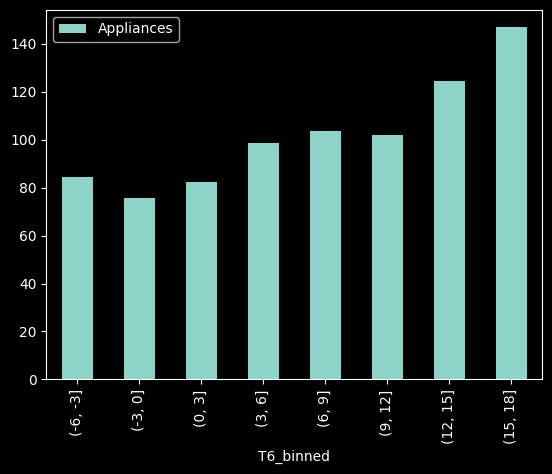

In [92]:
min_T6 = train_data_temp['T6'].min()
max_T6 = train_data_temp['T6'].max()

print(f"Minimum value of T6: {min_T6}")
print(f"Maximum value of T6: {max_T6}")

bin_edges = np.arange(-6, 21, 3)
train_data_temp['T6_binned'] = pd.cut(train_data_temp['T6'], bins=bin_edges)

train_data_temp.loc[:, ["T6_binned", "Appliances"]].groupby("T6_binned").mean().plot.bar()


## RH_6

RH_6, Humidity outside the building (north side), in %

The energy usage of appliances fluctuates with the outside humidity initially it decreases as humidity increases to around 51%, then it rises until humidity hits 81%, after which it decreases again, possibly indicating different energy needs under varying humidity levels.


Minimum value of RH_6: 1.0
Maximum value of RH_6: 99.9


<Axes: xlabel='RH_6_binned'>

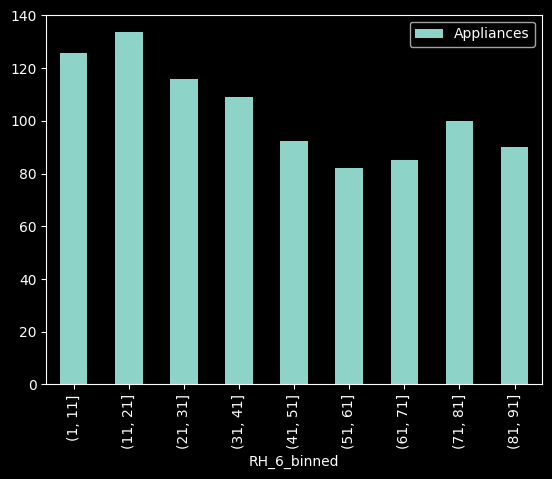

In [95]:
min_RH_6 = train_data_temp['RH_6'].min()
max_RH_6 = train_data_temp['RH_6'].max()

print(f"Minimum value of RH_6: {min_RH_6}")
print(f"Maximum value of RH_6: {max_RH_6}")

bin_edges = np.arange(1, 99, 10)
train_data_temp['RH_6_binned'] = pd.cut(train_data_temp['RH_6'], bins=bin_edges)

train_data_temp.loc[:, ["RH_6_binned", "Appliances"]].groupby("RH_6_binned").mean().plot.bar()


## T7

T7, Temperature in ironing room , in Celsius


As the temperature in the ironing room increases from 15 degrees to 24 degrees Celsius, the energy usage of appliances generally tends to increase, suggesting that higher temperatures in the room might correspond to increased appliance activity or energy use.


Minimum value of T7: 15.39
Maximum value of T7: 23.56666666666669


<Axes: xlabel='T7_binned'>

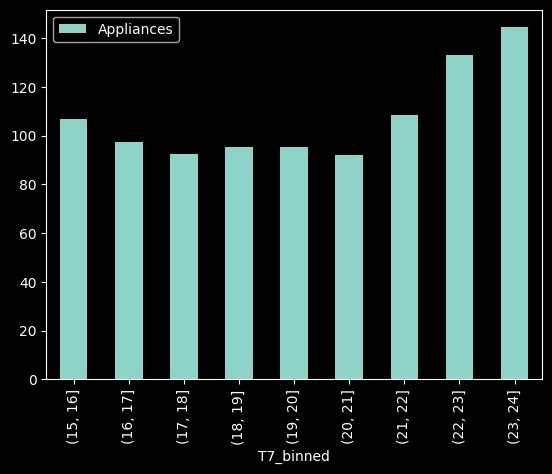

In [106]:
min_T7 = train_data_temp['T7'].min()
max_T7 = train_data_temp['T7'].max()

print(f"Minimum value of T7: {min_T7}")
print(f"Maximum value of T7: {max_T7}")

bin_edges = np.arange(15, 25, 1)
train_data_temp['T7_binned'] = pd.cut(train_data_temp['T7'], bins=bin_edges)

train_data_temp.loc[:, ["T7_binned", "Appliances"]].groupby("T7_binned").mean().plot.bar()


## RH_7

RH_7, Humidity in ironing room, in %

While appliance energy usage is high at 23-26% humidity in the ironing room, it drops to around 100 Wh for other humidity levels, suggesting that except for this specific humidity range, the humidity level doesn't significantly affect the appliance energy usage in the ironing room.

Minimum value of RH_7: 23.2
Maximum value of RH_7: 51.4


<Axes: xlabel='RH_7_binned'>

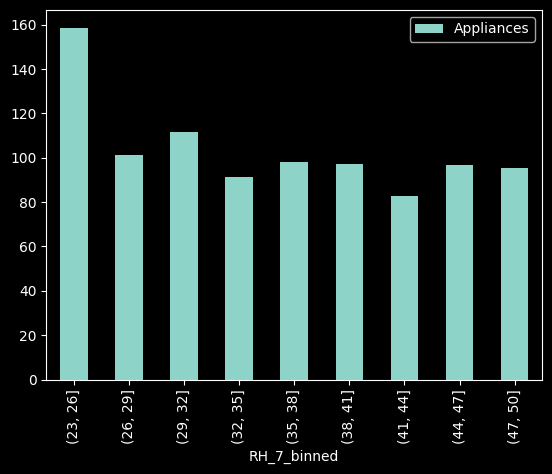

In [116]:
min_RH_7 = train_data_temp['RH_7'].min()
max_RH_7 = train_data_temp['RH_7'].max()

print(f"Minimum value of RH_7: {min_RH_7}")
print(f"Maximum value of RH_7: {max_RH_7}")

bin_edges = np.arange(23, 51, 3)
train_data_temp['RH_7_binned'] = pd.cut(train_data_temp['RH_7'], bins=bin_edges)

train_data_temp.loc[:, ["RH_7_binned", "Appliances"]].groupby("RH_7_binned").mean().plot.bar()


## T8

T8, Temperature in teenager room 2, in Celsius


In the teenager's room, as the temperature initially rises from 16 to 20 degrees Celsius, the appliance energy usage increases. However, between 20 to 22 degrees, energy usage drops, before it increases again as the temperature rises further, indicating a complex relationship between temperature and energy usage in this room.

Minimum value of T8: 16.3066666666667
Maximum value of T8: 25.2


<Axes: xlabel='T8_binned'>

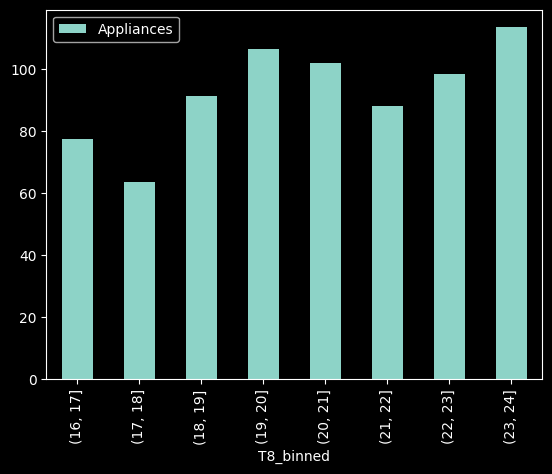

In [118]:
min_T8 = train_data_temp['T8'].min()
max_T8 = train_data_temp['T8'].max()

print(f"Minimum value of T8: {min_T8}")
print(f"Maximum value of T8: {max_T8}")

bin_edges = np.arange(16, 25, 1)
train_data_temp['T8_binned'] = pd.cut(train_data_temp['T8'], bins=bin_edges)

train_data_temp.loc[:, ["T8_binned", "Appliances"]].groupby("T8_binned").mean().plot.bar()


## RH_8

RH_8, Humidity in teenager room 2, in %

For the teenager's room, higher humidity levels 29-35% lead to greater energy usage. However, as humidity continues to rise above 35%, the energy usage starts to drop, reaching a low at 53-56%. This suggests that more energy is consumed to maintain comfort at moderate humidity levels, but less energy is needed at very high humidity levels.

Minimum value of RH_8: 29.6
Maximum value of RH_8: 58.78


<Axes: xlabel='RH_8_binned'>

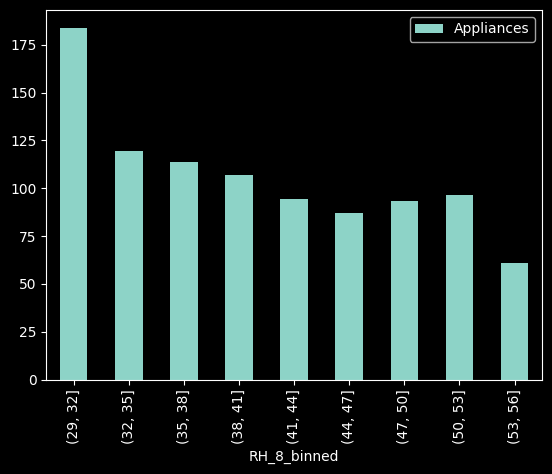

In [122]:
min_RH_8 = train_data_temp['RH_8'].min()
max_RH_8 = train_data_temp['RH_8'].max()

print(f"Minimum value of RH_8: {min_RH_8}")
print(f"Maximum value of RH_8: {max_RH_8}")

bin_edges = np.arange(29, 58, 3)
train_data_temp['RH_8_binned'] = pd.cut(train_data_temp['RH_8'], bins=bin_edges)

train_data_temp.loc[:, ["RH_8_binned", "Appliances"]].groupby("RH_8_binned").mean().plot.bar()


<Axes: xlabel='date'>

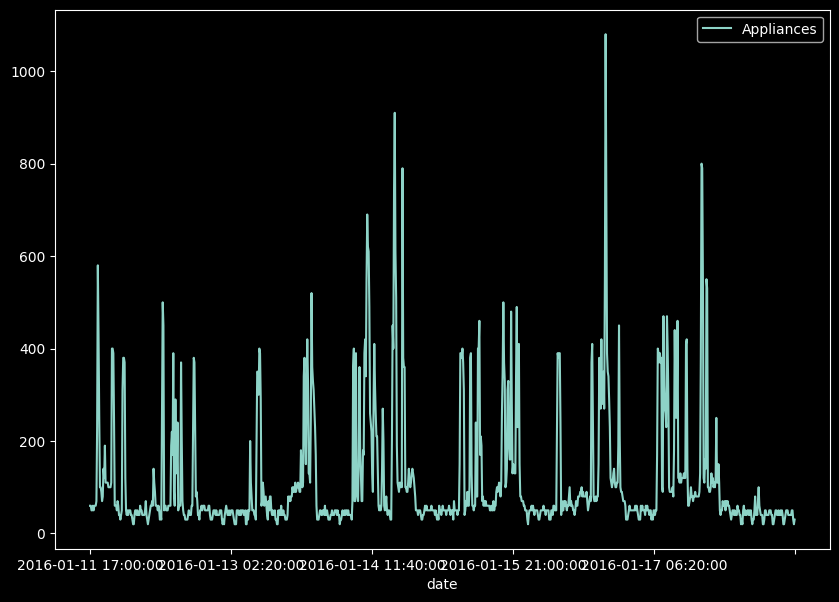

In [54]:
train_data[0:1000].plot(x="date", y="Appliances",figsize=(10,7))

In [31]:
test_data.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,0,21.926667,35.5,19.2900,37.500000,22.39,34.000000,21.39,32.225714,20.5,...,20.200000,32.400000,4.10,758.00,82.000000,3.0,40.0,1.2,10.668196,10.668196
1,0,21.890000,35.4,19.2225,37.425000,22.39,34.090000,21.35,32.200000,20.5,...,20.200000,32.400000,3.95,758.05,82.166667,3.0,40.0,1.1,48.467852,48.467852
2,0,21.890000,35.4,19.2000,37.466667,22.39,33.963333,21.29,32.277143,20.5,...,20.200000,32.290000,3.80,758.10,82.333333,3.0,40.0,1.0,36.388536,36.388536
3,0,21.890000,35.4,19.1000,37.590000,22.39,33.900000,21.29,32.334000,20.5,...,20.175000,32.290000,3.65,758.15,82.500000,3.0,40.0,0.9,17.198176,17.198176
4,0,21.890000,35.4,19.1000,37.590000,22.39,33.966667,21.29,32.290000,20.5,...,20.166667,32.563333,3.50,758.20,82.666667,3.0,40.0,0.8,7.200588,7.200588


### Building a first submission

For a first submission, let's just take the average consumption for the appliances of the training set, and use this value for all test samples:

In [32]:
average_consumption = train_data["Appliances"].mean()
print(average_consumption)

98.75133333333333


Let's put this in a numpy array with length of our test dataset. Normally, 'predictions' will be the output of your model here, instead of just creating this guess:

In [33]:
predictions = np.full(test_data.shape[0], average_consumption)
len(predictions)

4735

Create a unique filename based on timestamp:

In [34]:
def generate_unique_filename(basename, file_ext):
    """Adds a timestamp to filenames for easier tracking of submissions, models, etc."""
    timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    return basename + '_' + timestamp + '.' + file_ext

Let's create our pandas dataframe and write it to csv. You can submit this file to Kaggle.

In [35]:
submission = pd.DataFrame(data=predictions, columns=["Appliances"])
submission.index.name = "Id"
submission.head()

,Appliances
Id,
0,98.751333
1,98.751333
2,98.751333
3,98.751333
4,98.751333


In [36]:
submission.to_csv(generate_unique_filename("average_submission", "csv"))